# Computational Illustration for Chapter 06: Regression and Regularization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# generate the data
m = 15
x = np.random.uniform(-1,1,m)
x.sort()
x[0] = -1
x[-1] = 1
y = x**3 - 4*x**2 + x + np.random.normal(0,1,m)

In the overparametrized regime, least squares with polynomials of high degree leads to overfitting

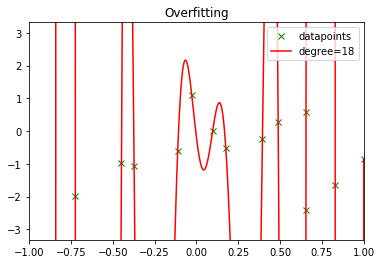

In [3]:
deg = 18
coefs = np.polyfit(x, y, deg)
p_overfit = np.poly1d(coefs)
# visualize the least squares output
grid = np.linspace(-1,1,500)
plt.plot(x,y,'gx',grid,p_overfit(grid),'r-')
plt.legend(labels=['datapoints','degree={}'.format(deg)],loc='best')
plt.title('Overfitting')
plt.axis((-1,1,-3*max(y),3*max(y)))
plt.show()

Perform a Tikhonov regularization

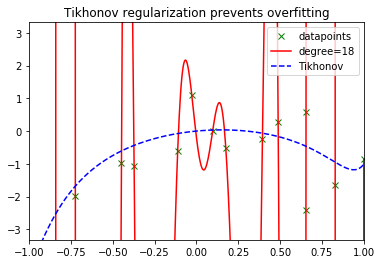

In [4]:
# define a "data matrix" (different from the X_tilde considered in the text)
X = np.zeros((m,deg+1))
for i in range(m):
    for j in range(deg):
        X[i,j] = x[i]**(deg-j)
# define and solve the corresponding linear system       
lamb = 1;
A = np.transpose(X)@X+lamb*lamb*np.identity(deg+1)
coefs_tik = np.linalg.solve(A,np.transpose(X)@y)
p_tik = np.poly1d(coefs_tik)
# visualize the result
plt.plot(x,y,'gx',grid,p_overfit(grid),'r-',grid,p_tik(grid),'b--')
plt.legend(labels=['datapoints','degree={}'.format(deg),'Tikhonov'],loc='best')
plt.title('Tikhonov regularization prevents overfitting')
plt.axis((-1,1,-3*max(y),3*max(y)))
plt.show()

Perform a regularization via a squared LASSO

Using license file /Users/foucart/gurobi.lic
Academic license - for non-commercial use only


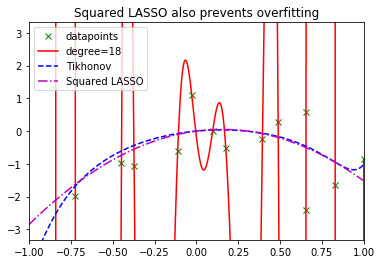

The number of nonzero coefficients is 2


In [5]:
# define and solve the nonnegative least squares problem
X_aux = np.row_stack(( np.column_stack((X,-X)), lamb*np.ones((1,2*deg+2)) ))
y_aux = np.row_stack((y[:,None],0))
Q = np.transpose(X_aux)@X_aux
c = (-2*np.transpose(X_aux)@y_aux).flatten()
d = np.transpose(y_aux)@y_aux
import gurobipy as gp
from gurobipy import GRB
sq_lasso = gp.Model("Squared_LASSO")
sq_lasso.setParam('OutputFlag',False)
nonneg = sq_lasso.addMVar(2*deg+2, lb=0, ub=GRB.INFINITY)
sq_lasso.setMObjective( Q, c, d, xQ_L=None, xQ_R=None, xc=nonneg, sense=GRB.MINIMIZE )
sq_lasso.optimize()
coefs_sq_lasso = nonneg.X[0:deg+1] - nonneg.X[deg+1:2*deg+2]
p_sq_lasso = np.poly1d(coefs_sq_lasso)
# visualize the result
plt.plot(x,y,'gx',grid,p_overfit(grid),'r-',grid,p_tik(grid),'b--',grid,p_sq_lasso(grid),'m-.')
plt.legend(labels=['datapoints','degree={}'.format(deg),'Tikhonov','Squared LASSO'],loc='best')
plt.title('Squared LASSO also prevents overfitting')
plt.axis((-1,1,-3*max(y),3*max(y)))
plt.show()
plt.show()
# Check the sparsity of the coefficient vector
print('The number of nonzero coefficients is',sum(abs(coefs_sq_lasso)>1e-5))